Number of layers: 4
Number of heads: 2
Epoch   5, Time (secs) 26.40: Training loss 3.0139, Validation loss 2.6618, Validation Accuracy 23.50%
Epoch  10, Time (secs) 52.28: Training loss 1.3261, Validation loss 1.0414, Validation Accuracy 45.43%
Epoch  15, Time (secs) 77.84: Training loss 0.5045, Validation loss 0.3446, Validation Accuracy 48.57%
Epoch  20, Time (secs) 103.57: Training loss 0.2057, Validation loss 0.1312, Validation Accuracy 48.57%
Epoch  25, Time (secs) 129.25: Training loss 0.1132, Validation loss 0.0682, Validation Accuracy 48.57%
Epoch  30, Time (secs) 154.81: Training loss 0.0744, Validation loss 0.0439, Validation Accuracy 48.57%
Epoch  35, Time (secs) 180.17: Training loss 0.0548, Validation loss 0.0317, Validation Accuracy 48.57%
Epoch  40, Time (secs) 205.44: Training loss 0.0432, Validation loss 0.0245, Validation Accuracy 48.57%
Epoch  45, Time (secs) 230.88: Training loss 0.0355, Validation loss 0.0196, Validation Accuracy 48.57%
Epoch  50, Time (secs) 256.5

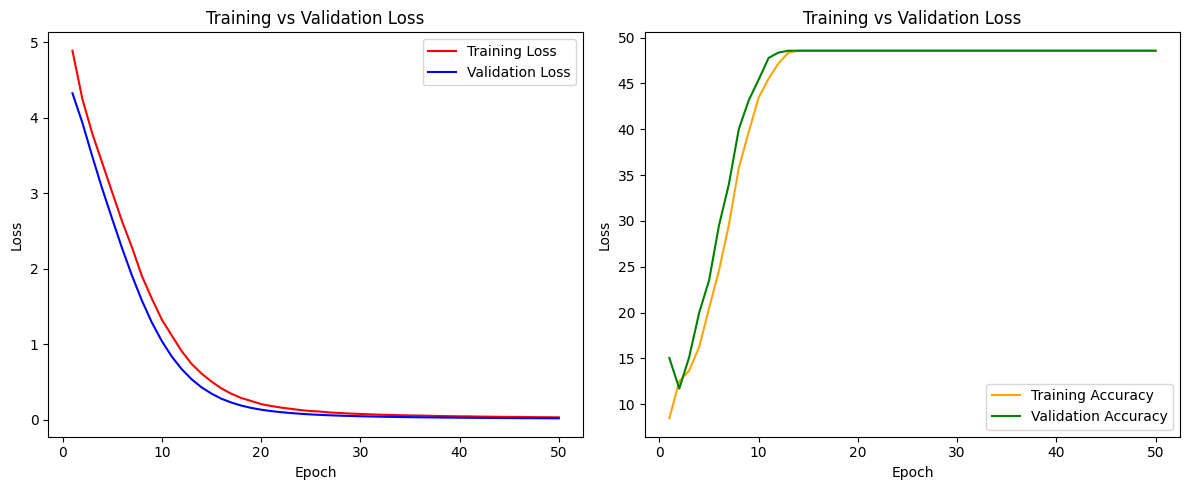

In [7]:
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch
import time

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import ast

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

MAX_LENGTH = 9
SOS_token = 0
EOS_token = 1
PAD_token = 2

# Read lines from the text file and extract English-French sentence pairs
english_to_french  = [
    ("I am cold", "J'ai froid"),
    ("You are tired", "Tu es fatigué"),
    ("He is hungry", "Il a faim"),
    ("She is happy", "Elle est heureuse"),
    ("We are friends", "Nous sommes amis"),
    ("They are students", "Ils sont étudiants"),
    ("The cat is sleeping", "Le chat dort"),
    ("The sun is shining", "Le soleil brille"),
    ("We love music", "Nous aimons la musique"),
    ("She speaks French fluently", "Elle parle français couramment"),
    ("He enjoys reading books", "Il aime lire des livres"),
    ("They play soccer every weekend", "Ils jouent au football chaque week-end"),
    ("The movie starts at 7 PM", "Le film commence à 19 heures"),
    ("She wears a red dress", "Elle porte une robe rouge"),
    ("We cook dinner together", "Nous cuisinons le dîner ensemble"),
    ("He drives a blue car", "Il conduit une voiture bleue"),
    ("They visit museums often", "Ils visitent souvent des musées"),
    ("The restaurant serves delicious food", "Le restaurant sert une délicieuse cuisine"),
    ("She studies mathematics at university", "Elle étudie les mathématiques à l'université"),
    ("We watch movies on Fridays", "Nous regardons des films le vendredi"),
    ("He listens to music while jogging", "Il écoute de la musique en faisant du jogging"),
    ("They travel around the world", "Ils voyagent autour du monde"),
    ("The book is on the table", "Le livre est sur la table"),
    ("She dances gracefully", "Elle danse avec grâce"),
    ("We celebrate birthdays with cake", "Nous célébrons les anniversaires avec un gâteau"),
    ("He works hard every day", "Il travaille dur tous les jours"),
    ("They speak different languages", "Ils parlent différentes langues"),
    ("The flowers bloom in spring", "Les fleurs fleurissent au printemps"),
    ("She writes poetry in her free time", "Elle écrit de la poésie pendant son temps libre"),
    ("We learn something new every day", "Nous apprenons quelque chose de nouveau chaque jour"),
    ("The dog barks loudly", "Le chien aboie bruyamment"),
    ("He sings beautifully", "Il chante magnifiquement"),
    ("They swim in the pool", "Ils nagent dans la piscine"),
    ("The birds chirp in the morning", "Les oiseaux gazouillent le matin"),
    ("She teaches English at school", "Elle enseigne l'anglais à l'école"),
    ("We eat breakfast together", "Nous prenons le petit déjeuner ensemble"),
    ("He paints landscapes", "Il peint des paysages"),
    ("They laugh at the joke", "Ils rient de la blague"),
    ("The clock ticks loudly", "L'horloge tic-tac bruyamment"),
    ("She runs in the park", "Elle court dans le parc"),
    ("We travel by train", "Nous voyageons en train"),
    ("He writes a letter", "Il écrit une lettre"),
    ("They read books at the library", "Ils lisent des livres à la bibliothèque"),
    ("The baby cries", "Le bébé pleure"),
    ("She studies hard for exams", "Elle étudie dur pour les examens"),
    ("We plant flowers in the garden", "Nous plantons des fleurs dans le jardin"),
    ("He fixes the car", "Il répare la voiture"),
    ("They drink coffee in the morning", "Ils boivent du café le matin"),
    ("The sun sets in the evening", "Le soleil se couche le soir"),
    ("She dances at the party", "Elle danse à la fête"),
    ("We play music at the concert", "Nous jouons de la musique au concert"),
    ("He cooks dinner for his family", "Il cuisine le dîner pour sa famille"),
    ("They study French grammar", "Ils étudient la grammaire française"),
    ("The rain falls gently", "La pluie tombe doucement"),
    ("She sings a song", "Elle chante une chanson"),
    ("We watch a movie together", "Nous regardons un film ensemble"),
    ("He sleeps deeply", "Il dort profondément"),
    ("They travel to Paris", "Ils voyagent à Paris"),
    ("The children play in the park", "Les enfants jouent dans le parc"),
    ("She walks along the beach", "Elle se promène le long de la plage"),
    ("We talk on the phone", "Nous parlons au téléphone"),
    ("He waits for the bus", "Il attend le bus"),
    ("They visit the Eiffel Tower", "Ils visitent la tour Eiffel"),
    ("The stars twinkle at night", "Les étoiles scintillent la nuit"),
    ("She dreams of flying", "Elle rêve de voler"),
    ("We work in the office", "Nous travaillons au bureau"),
    ("He studies history", "Il étudie l'histoire"),
    ("They listen to the radio", "Ils écoutent la radio"),
    ("The wind blows gently", "Le vent souffle doucement"),
    ("She swims in the ocean", "Elle nage dans l'océan"),
    ("We dance at the wedding", "Nous dansons au mariage"),
    ("He climbs the mountain", "Il gravit la montagne"),
    ("They hike in the forest", "Ils font de la randonnée dans la forêt"),
    ("The cat meows loudly", "Le chat miaule bruyamment"),
    ("She paints a picture", "Elle peint un tableau"),
    ("We build a sandcastle", "Nous construisons un château de sable"),
    ("He sings in the choir", "Il chante dans le chœur"),
    ("They ride bicycles", "Ils font du vélo"),
    ("The coffee is hot", "Le café est chaud"),
    ("She wears glasses", "Elle porte des lunettes"),
    ("We visit our grandparents", "Nous rendons visite à nos grands-parents"),
    ("He plays the guitar", "Il joue de la guitare"),
    ("They go shopping", "Ils font du shopping"),
    ("The teacher explains the lesson", "Le professeur explique la leçon"),
    ("She takes the train to work", "Elle prend le train pour aller au travail"),
    ("We bake cookies", "Nous faisons des biscuits"),
    ("He washes his hands", "Il se lave les mains"),
    ("They enjoy the sunset", "Ils apprécient le coucher du soleil"),
    ("The river flows calmly", "La rivière coule calmement"),
    ("She feeds the cat", "Elle nourrit le chat"),
    ("We visit the museum", "Nous visitons le musée"),
    ("He fixes his bicycle", "Il répare son vélo"),
    ("They paint the walls", "Ils peignent les murs"),
    ("The baby sleeps peacefully", "Le bébé dort paisiblement"),
    ("She ties her shoelaces", "Elle attache ses lacets"),
    ("We climb the stairs", "Nous montons les escaliers"),
    ("He shaves in the morning", "Il se rase le matin"),
    ("They set the table", "Ils mettent la table"),
    ("The airplane takes off", "L'avion décolle"),
    ("She waters the plants", "Elle arrose les plantes"),
    ("We practice yoga", "Nous pratiquons le yoga"),
    ("He turns off the light", "Il éteint la lumière"),
    ("They play video games", "Ils jouent aux jeux vidéo"),
    ("The soup smells delicious", "La soupe sent délicieusement bon"),
    ("She locks the door", "Elle ferme la porte à clé"),
    ("We enjoy a picnic", "Nous profitons d'un pique-nique"),
    ("He checks his email", "Il vérifie ses emails"),
    ("They go to the gym", "Ils vont à la salle de sport"),
    ("The moon shines brightly", "La lune brille intensément"),
    ("She catches the bus", "Elle attrape le bus"),
    ("We greet our neighbors", "Nous saluons nos voisins"),
    ("He combs his hair", "Il se peigne les cheveux"),
    ("They wave goodbye", "Ils font un signe d'adieu")
]

class Vocab:
    def __init__(self):
        # Initialize dictionaries for word to index and index to word mappings
        self.word2index = {'<SOS>': 0, '<EOS>': 1, '<PAD>': 2}
        self.index2word = {0: '<SOS>', 1: '<EOS>', 2: '<PAD>'}
        self.word_count = {}  # Keep track of word frequencies
        self.n_words = 3  # Start counting from 2 to account for special tokens

    def add_sentence(self, sentence):
        # Add all words in a sentence to the vocabulary
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        # Add a word to the vocabulary
        if word not in self.word2index:
            # Assign a new index to the word and update mappings
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.word_count[word] = 1
            self.n_words += 1
        else:
            # Increment word count if the word already exists in the vocabulary
            self.word_count[word] += 1

# Custom Dataset class for English to French sentences
class TranslationDataset(Dataset):
    def __init__(self, pairs):
        self.first_vocab = Vocab()
        self.second_vocab = Vocab()
        self.pairs = []

        # Process each English-French pair
        for first, second in pairs:
            self.first_vocab.add_sentence(first)
            self.second_vocab.add_sentence(second)
            self.pairs.append((first, second))

        # Separate English and French sentences
        self.first_sentences = [pair[0] for pair in self.pairs]
        self.second_sentences = [pair[1] for pair in self.pairs]

    def pad_sentence(self, sentence, max_length):
        # Split the sentence into words
        words = sentence.split()
        # If the sentence is shorter than max_length, pad it with '<PAD>'
        if len(words) < max_length:
            words += ['<PAD>'] * (max_length - len(words))
        # If the sentence is longer than max_length, truncate it
        elif len(words) > max_length:
            words = words[:max_length]
        return ' '.join(words)

    def __len__(self):
        # Return the number of sentence pairs
        return len(self.pairs)

    def __getitem__(self, idx):
        # Get the sentences by index
        first_sentence = self.pad_sentence(self.first_sentences[idx], max_length=MAX_LENGTH)
        second_sentence = self.pad_sentence(self.second_sentences[idx], max_length=MAX_LENGTH)
        input_indices = [self.second_vocab.word2index[word] for word in second_sentence.split()] + [1]
        target_indices = [self.first_vocab.word2index[word] for word in first_sentence.split()] + [1]

        return torch.tensor(input_indices, dtype=torch.long), torch.tensor(target_indices, dtype=torch.long)

class OptimusTransformer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, num_heads):
        super(OptimusTransformer, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.output_embedding = nn.Embedding(output_size, hidden_size)
        encoder_layers = nn.TransformerEncoderLayer(hidden_size, num_heads, batch_first=True)
        decoder_layers = nn.TransformerDecoderLayer(hidden_size, num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layers, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, src, tgt):
        src = self.embedding(src)
        tgt = self.output_embedding(tgt)
        memory = self.transformer_encoder(src)
        transformer_output = self.transformer_decoder(tgt, memory)
        output = self.fc(transformer_output)
        return output

def train_model(model, criterion, optimizer, epochs, training_loader, validation_loader, update_interval):

    training_losses = []
    training_accuracies = []
    validation_losses = []
    validation_accuracies = []

    starting_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        total_correct_train = 0
        total_samples_train = 0
        start_train = time.time()

        for inputs, targets in training_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs, targets[:, :-1])  # Exclude <EOS> token from inputs

            # Calculate loss
            loss = criterion(outputs.view(-1, outputs.size(-1)), targets[:, 1:].contiguous().view(-1))  # Exclude <SOS> token from targets

            # Backward pass
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Compute training accuracy
            predicted = torch.argmax(outputs, dim=-1)
            total_correct_train += (predicted == targets[:, 1:]).sum().item()
            total_samples_train += targets[:, 1:].nelement()

        training_loss = running_loss / len(training_loader)
        training_losses.append(training_loss)

        training_accuracy = total_correct_train / total_samples_train * 100
        training_accuracies.append(training_accuracy)

        end_train = time.time()
        training_time = end_train - start_train

        model.eval()
        start_valid = time.time()

        with torch.no_grad():
            total_correct = 0
            total_samples = 0
            running_validation_loss = 0.0  # Added this line

            for inputs, targets in validation_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs, targets[:, :-1])  # Exclude <EOS> token from inputs

                # Calculate validation loss
                validation_loss = criterion(outputs.view(-1, outputs.size(-1)), targets[:, 1:].contiguous().view(-1))  # Exclude <SOS> token from targets
                running_validation_loss += validation_loss.item()  # Added this line

                # Calculate accuracy
                predicted = torch.argmax(outputs, dim=-1)
                total_correct += (predicted == targets[:, 1:]).sum().item()
                total_samples += targets[:, 1:].nelement()

            validation_loss = running_validation_loss / len(validation_loader)  # Added this line
            validation_losses.append(validation_loss)  # Added this line

            validation_accuracy = total_correct / total_samples * 100
            validation_accuracies.append(validation_accuracy)

        end_valid = time.time()
        validation_time = end_valid - start_valid

        if(epoch + 1) % update_interval == 0:
            rounds_end_time = time.time()
            rounds_time = rounds_end_time - starting_time
            print('Epoch {:3d}, Time (secs) {:.2f}: Training loss {:.4f}, Validation loss {:.4f}, Validation Accuracy {:.2f}%'.format(epoch + 1, rounds_time, training_losses[-1], validation_losses[-1], validation_accuracies[-1]))

    total_time = time.time() - starting_time

    print(f'\nTotal Duration: {total_time:.2f}s')
    print(f'Training Duration: {training_time:.2f}s')
    print(f'Inference Duration: {validation_time:.2f}s')

    print(f'\nFinal Training Loss: {training_losses[-1]:.4f}')
    print(f'Final Validation Loss: {validation_losses[-1]:.4f}')
    print(f'Final Training Accuracy: {training_accuracies[-1]:.2f}%')
    print(f'Final Validation Accuracy: {validation_accuracies[-1]:.2f}%')

    return training_losses, validation_losses, training_accuracies, validation_accuracies, training_time, validation_time

dataset = TranslationDataset(english_to_french)
training_loader = DataLoader(dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(dataset, batch_size=32, shuffle=False)

learning_rate = 0.0001
epochs = 50

hidden_size = 512
num_layers = 4
num_heads = 2

input_size = len(dataset.second_vocab.word2index)
output_size = len(dataset.first_vocab.word2index)

model = OptimusTransformer(input_size, hidden_size, output_size, num_layers, num_heads).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_token)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f'Number of layers: {num_layers}')
print(f'Number of heads: {num_heads}')
training_losses, validation_losses, training_accuracies, validation_accuracies, training_time, validation_time = train_model(model, criterion, optimizer, epochs, training_loader, validation_loader, update_interval=5)

def validation_func(model, second_sentence, max_length, first_vocab, second_vocab, device):

    second_indices = [second_vocab.word2index.get(word, second_vocab.word2index['<PAD>']) for word in second_sentence.split()]
    second_indices += [second_vocab.word2index['<EOS>']]  # Add <EOS> token
    second_indices = torch.tensor(second_indices, dtype=torch.long).unsqueeze(0).to(device)  # Move to model's device

    # Initialize French translation with <SOS> token
    first_indices = [first_vocab.word2index['<SOS>']]

    # Disable gradient computation
    with torch.no_grad():
        model.eval()
        # Loop to generate French translation
        for _ in range(max_length):
            # Convert French translation indices to tensor
            first_tensor = torch.tensor(first_indices, dtype=torch.long).unsqueeze(0).to(device)  # Move to model's device

            # Predict the next token in the French translation
            output = model(second_indices, first_tensor)
            next_token_index = torch.argmax(output[:, -1, :], dim=-1).item()

            # If the predicted token is <EOS>, stop generating
            if next_token_index == first_vocab.word2index['<EOS>']:
                break

            # Add the predicted token to the French translation after <SOS>
            first_indices.append(next_token_index)

    # Convert french translation indices to words
    first_sentence = ' '.join([first_vocab.index2word[index] for index in first_indices[1:]])  # Exclude <SOS>
    return first_sentence

num_examples = 3
for i in range(num_examples):
    sentence = dataset.second_sentences[i]
    translation = validation_func(model, sentence, len(sentence.split()), dataset.first_vocab, dataset.second_vocab, device)
    # Print the original and translated sentences
    print(f'Example {i + 1}:')
    print(f'Input: {sentence}, Predicted: {translation}')
    print()

epochs_range = range(1, epochs + 1)

# Plot Training & Validation Losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_losses, label='Training Loss', color='red')
plt.plot(epochs_range, validation_losses, label='Validation Loss', color='blue')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_accuracies, label='Training Accuracy', color='orange')
plt.plot(epochs_range, validation_accuracies, label='Validation Accuracy', color='green')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()